## ✅ Summary of QC Pipeline

- Removed low-quality cell lines using **MAD-based outlier filtering**.
- Considered two key metrics: **total expression** and **number of expressed genes**.
- Dropped cell lines with values exceeding 5 MADs from the median.
- Final cleaned matrix saved for downstream feature engineering or PCA.

Next step: normalization and feature selection (see Chapters 7 and 8 in sc-best-practices).


In [2]:
# 📚 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import median_abs_deviation

# 📊 Plot settings
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)


In [3]:
# 📥 Load transposed data
fpkm_df = pd.read_parquet("../../data/sc_data/rnaseq_fpkm.parquet")

# 🧹 Remove the first 3 rows (metadata: dataset_name, data_source, gene_id)
fpkm_df = fpkm_df.iloc[4:].copy()

# 🧠 Rename first column to "SANGER_MODEL_ID" and set it as index
fpkm_df = fpkm_df.rename(columns={fpkm_df.columns[0]: "SANGER_MODEL_ID"})
fpkm_df = fpkm_df.set_index("SANGER_MODEL_ID")

# 🧬 Transpose to get cell lines as rows, genes as columns
fpkm_df = fpkm_df.transpose()

# 💡 Convert all values to numeric and fill missing with 0
fpkm_df = fpkm_df.apply(pd.to_numeric, errors="coerce").fillna(0.0)

# ✅ Confirm shape
print(f"✅ Cleaned expression matrix shape: {fpkm_df.shape}")
fpkm_df.head()


✅ Cleaned expression matrix shape: (1431, 37602)


SANGER_MODEL_ID,SIDG00001,SIDG00002,SIDG00003,SIDG00004,SIDG00005,SIDG00006,SIDG00007,SIDG00008,SIDG00009,SIDG00010,...,SIDG42469,SIDG42470,SIDG42471,SIDG42472,SIDG42473,SIDG42474,SIDG42475,SIDG42479,SIDG42480,SIDG42481
SIDM00001,0.16,0.73,0.01,0.10,0.00,0.00,0.00,0.92,0.00,0.00,...,0.86,0.00,2.73,8.44,0.0,3.53,4.27,2.50,1.81,0.62
SIDM00002,0.22,1.69,0.00,0.21,0.20,0.16,0.01,0.03,0.00,0.29,...,0.58,0.00,8.85,15.77,0.0,6.67,12.70,3.24,1.49,0.16
SIDM00003,0.14,3.33,0.00,8.41,0.24,0.00,0.00,0.00,0.01,0.09,...,3.83,0.09,8.62,51.84,0.0,7.28,12.90,2.19,1.70,0.56
SIDM00005,0.87,2.04,0.00,0.23,1.48,0.05,0.15,2.42,0.02,0.14,...,1.01,0.00,3.96,6.87,0.0,3.37,7.11,7.52,5.02,0.33
SIDM00006,0.15,2.03,0.01,23.22,0.28,0.00,0.01,0.00,0.01,0.16,...,4.49,0.00,7.51,141.70,0.0,3.48,8.75,2.94,1.29,0.11


In [4]:
# 🔍 Calculate per-cell QC metrics and log thresholds
qc_df = pd.DataFrame(index=fpkm_df.index)
qc_df["total_counts"] = fpkm_df.sum(axis=1)
qc_df["n_genes"] = (fpkm_df > 0).sum(axis=1)
qc_df["log_total_counts"] = np.log1p(qc_df["total_counts"])
qc_df["log_n_genes"] = np.log1p(qc_df["n_genes"])

# 🧾 Log MAD-based thresholds for outlier detection
def log_mad_thresholds(series, n_mads=5, label=""):
    med = np.median(series)
    mad = median_abs_deviation(series)
    low = med - n_mads * mad
    high = med + n_mads * mad
    print(f"📏 {label}: median={med:.2f}, MAD={mad:.2f}, low={low:.2f}, high={high:.2f}")

log_mad_thresholds(qc_df["log_total_counts"], 5, "log_total_counts")
log_mad_thresholds(qc_df["log_n_genes"], 5, "log_n_genes")

qc_df.describe()


📏 log_total_counts: median=12.58, MAD=0.09, low=12.15, high=13.02
📏 log_n_genes: median=9.99, MAD=0.04, low=9.80, high=10.18


,total_counts,n_genes,log_total_counts,log_n_genes
count,1431.000000,1431.000000,1431.000000,1431.000000
mean,315044.772387,21775.059399,12.637475,9.986744
std,76027.708174,1304.914292,0.203365,0.060683
min,219046.880000,16634.000000,12.297046,9.719264
25%,270407.160000,20983.000000,12.507688,9.951515
50%,291069.400000,21773.000000,12.581320,9.988472
75%,325549.775000,22626.000000,12.693274,10.026899
max,822906.320000,27714.000000,13.620599,10.229729


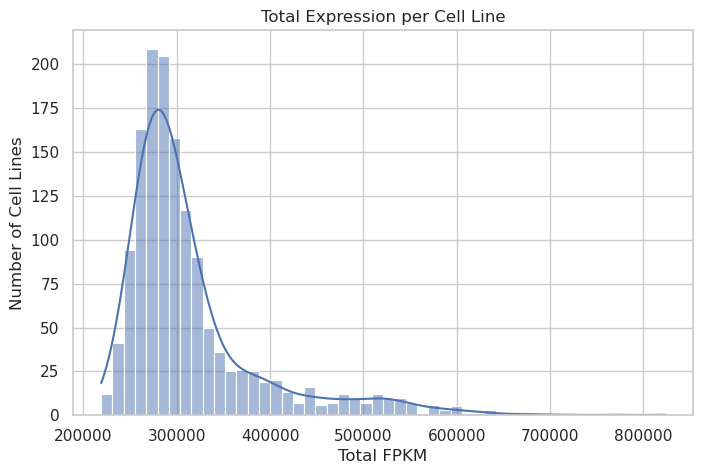

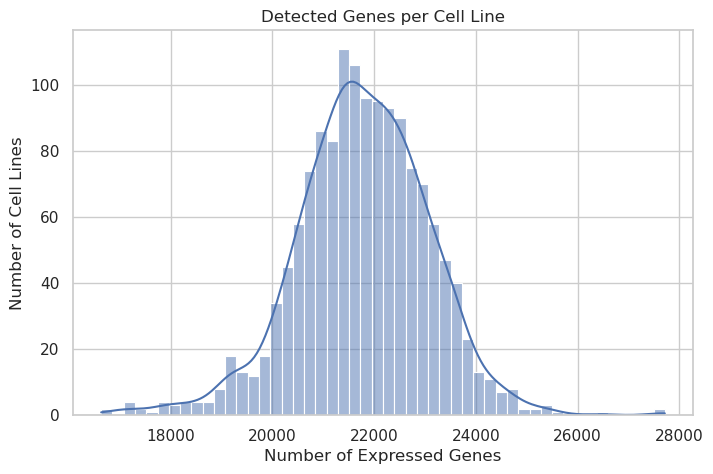

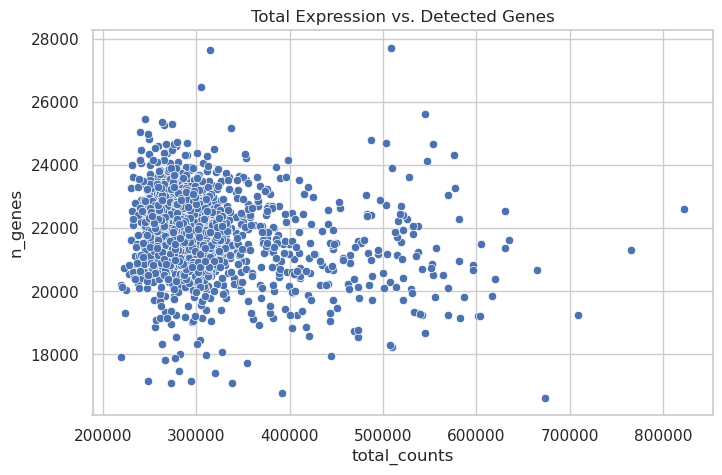

In [5]:
# 📊 Visual inspection of QC metrics
sns.histplot(qc_df["total_counts"], bins=50, kde=True)
plt.title("Total Expression per Cell Line")
plt.xlabel("Total FPKM")
plt.ylabel("Number of Cell Lines")
plt.show()

sns.histplot(qc_df["n_genes"], bins=50, kde=True)
plt.title("Detected Genes per Cell Line")
plt.xlabel("Number of Expressed Genes")
plt.ylabel("Number of Cell Lines")
plt.show()

sns.scatterplot(data=qc_df, x="total_counts", y="n_genes")
plt.title("Total Expression vs. Detected Genes")
plt.show()


In [6]:
# 🚨 MAD outlier detection
def is_outlier(series, n_mads=5):
    med = np.median(series)
    mad = median_abs_deviation(series)
    return (series < med - n_mads * mad) | (series > med + n_mads * mad)

qc_df["outlier_counts"] = is_outlier(qc_df["log_total_counts"])
qc_df["outlier_genes"] = is_outlier(qc_df["log_n_genes"])
qc_df["is_outlier"] = qc_df[["outlier_counts", "outlier_genes"]].any(axis=1)

print(f"⚠️ Number of cell lines flagged as outliers: {qc_df['is_outlier'].sum()}")


⚠️ Number of cell lines flagged as outliers: 120


In [7]:
# 🧹 Remove outlier cell lines
clean_df = fpkm_df.loc[~qc_df["is_outlier"]].copy()
print(f"✅ Filtered dataset shape: {clean_df.shape}")


✅ Filtered dataset shape: (1311, 37602)


In [8]:
# 💾 Save cleaned dataset
clean_df.reset_index().to_parquet("../../data/sc_data/rnaseq_fpkm_qc_filtered.parquet", index=False)
print("📁 Saved QC-filtered dataset to 'rnaseq_fpkm_qc_filtered.parquet'")


📁 Saved QC-filtered dataset to 'rnaseq_fpkm_qc_filtered.parquet'
